In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.decomposition import PCA
#Principal component analysis 
from sklearn.feature_selection import RFE
#Recursive Feature Elimination, but need the estimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

dataset = pd.read_csv('../example-data/kaggle-data.csv')

In [22]:
# dataset.keys()

X = dataset[['spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree']]
# X
#The data columns are at the different scales
#so we may need to standardize the data I guess

y_gibbs = dataset['formation_energy_ev_natom']

X_train, X_test, y_train, y_test = train_test_split(
                                   X, y_gibbs, test_size=0.15, random_state=42)

In [23]:
X_train_categorical = X_train['spacegroup']
X_train_numerical = X_train[['number_of_total_atoms','percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree']]
X_train_spacegroup = X_train['spacegroup']

X_test_categorical = X_test['spacegroup']
X_test_numerical = X_test[['number_of_total_atoms','percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree']]
X_test_spacegroup = X_test['spacegroup']
# print type(X_train_spacegroup)

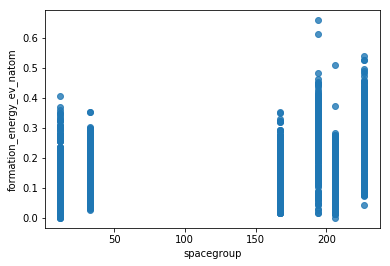

In [24]:
sns.regplot(x=dataset['spacegroup'], y=dataset['formation_energy_ev_natom'],fit_reg=False)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1240921d0>,
      dtype=object)

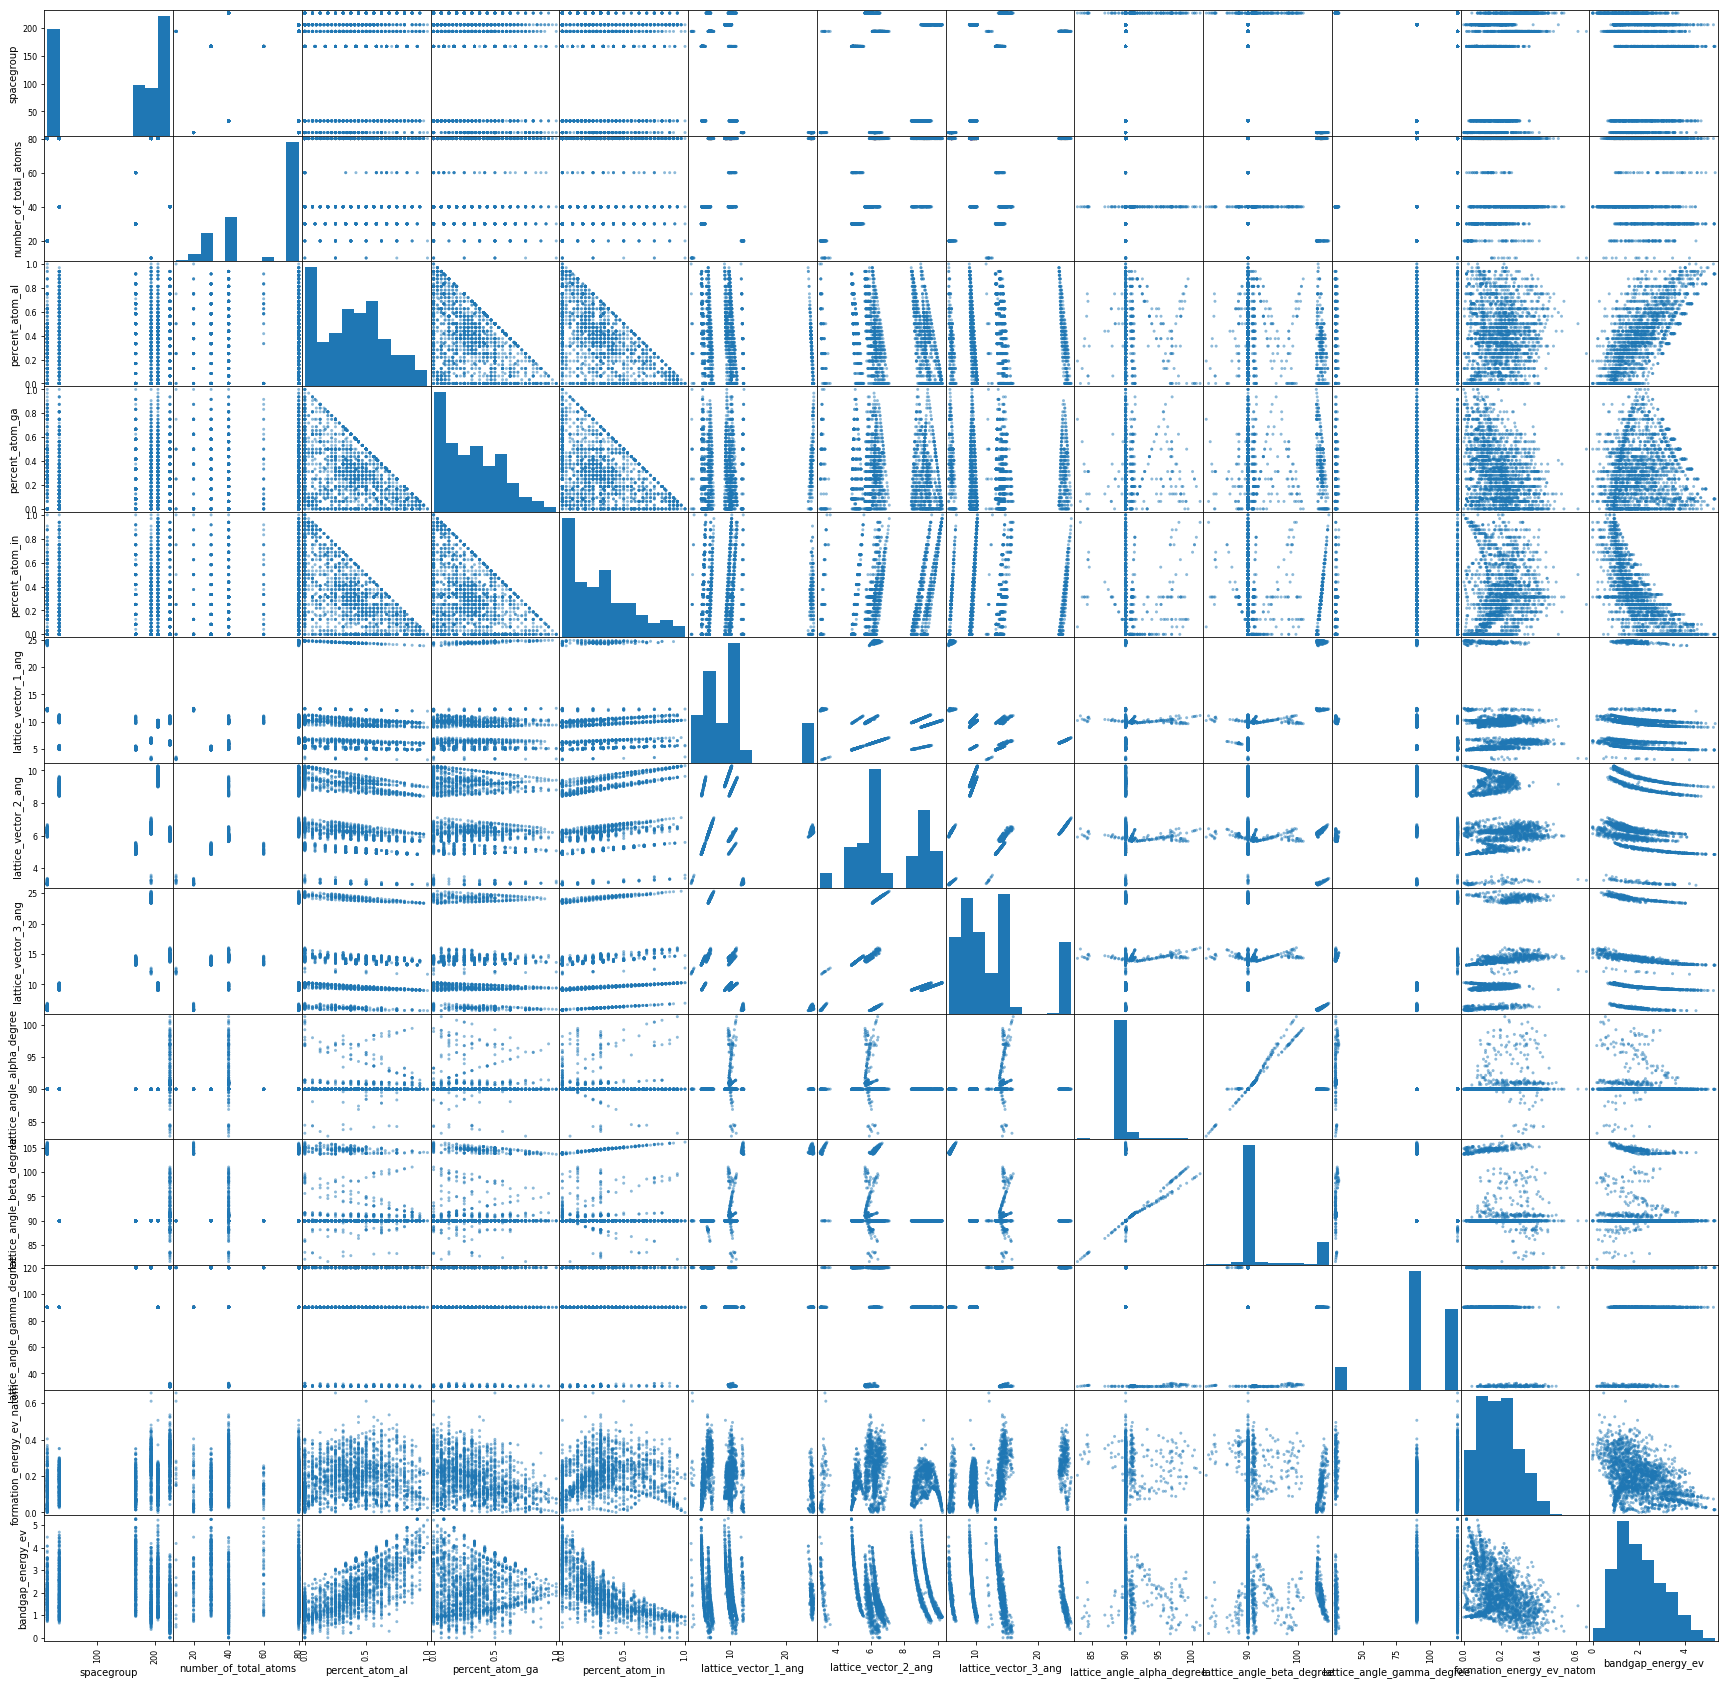

In [25]:
dataset_no_id = dataset.drop(columns=['id'], axis=1)
pd.plotting.scatter_matrix(dataset_no_id, figsize=(30,30))


Index([u'spacegroup', u'number_of_total_atoms', u'percent_atom_al',
       u'percent_atom_ga', u'percent_atom_in', u'lattice_vector_1_ang',
       u'lattice_vector_2_ang', u'lattice_vector_3_ang',
       u'lattice_angle_alpha_degree', u'lattice_angle_beta_degree',
       u'lattice_angle_gamma_degree'],
      dtype='object')


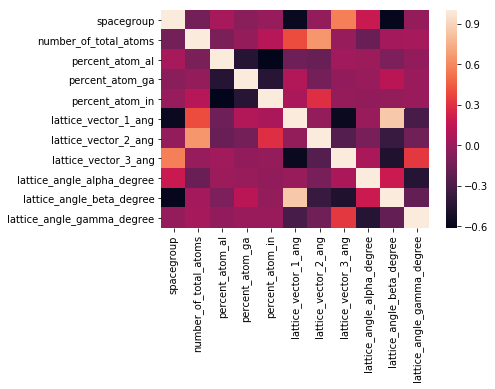

In [26]:
dataset_no_id_no_target = dataset.drop(columns=['id','formation_energy_ev_natom','bandgap_energy_ev'])
# dataset_no_id_no_target
corr = dataset_no_id_no_target.corr()
print corr.columns
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [27]:
X_train_std = StandardScaler().fit_transform(X_train_numerical)
X_test_std = StandardScaler().fit_transform(X_test_numerical)

In [28]:
##we have 3000 points together, log10(3000) around 3.4 
##we might need 4 features in total
##try using PCA
# n_components = [2,3,4]
# for n_component in n_components:
#     pca_test = PCA(n_components= n_component)
#     pca_test_fit = pca_test.fit(X_train)

#     print("Explained Variance: %s with %s components") %(pca_test_fit.explained_variance_ratio_,n_component)
#     print("Explained Variance of Cumsum: %s with %s components") %(pca_test_fit.explained_variance_ratio_.cumsum(), 
#                                                                    n_component)

#---------------output---------------------#
# Retain 93.3% of the variance with 3 components
# 3 components is a good number of features
#---------------output--------------------#

#try using standarized data because of data with multi-scale
n_components = [6] #2,3,4,5,6]
for n_component in n_components:
    pca_test = PCA(n_components= n_component)
    pca_test_fit = pca_test.fit(X_train_std)

    print("Explained Variance: %s with %s components") %(pca_test_fit.explained_variance_ratio_,n_component)
    print("Explained Variance of Cumsum: %s with %s components") %(pca_test_fit.explained_variance_ratio_.cumsum(), 
                                                                   n_component)
    
#---------------output---------------------#
# After standardize the data without splitting out categorical data: spacegroup:
# Only retain 59.7% of the variance with 3 components
# Only retain 73.0% of the variance with 4 components
# Only retain 84.2% of the variance with 5 components
# Only retain 92.2% of the variance with 6 components
#---------------output--------------------#

#---------------output---------------------#
# After standardize the data with splitting out categorical data:spacegroup:
# Only retain 60.8% of the variance with 3 components
# Only retain 74.7% of the variance with 4 components
# Only retain 86.6% of the variance with 5 components
# Only retain 95.1% of the variance with 6 components
# so it improves after splitting the mixed data types
#---------------output--------------------#

#---------------output---------------------#
# After standardize the data with splitting out categorical data:spacegroup 
# and number_of_total_atoms:
# Only retain 64.3% of the variance with 3 components
# Only retain 78.3% of the variance with 4 components
# Only retain 90.8% of the variance with 5 components
# Only retain 95.5% of the variance with 6 components
# so it improves after splitting the mixed data types
# should we take number_of_total_atoms as categorical
#---------------output--------------------#

Explained Variance: [0.25521863 0.20506471 0.14837484 0.13824729 0.11729874 0.08610524] with 6 components
Explained Variance of Cumsum: [0.25521863 0.46028334 0.60865818 0.74690547 0.86420421 0.95030946] with 6 components


In [29]:
#decided to use 6 components by using PCA values
pca = PCA(n_components= 6)
pca_fit_X_train_std = pca.fit_transform(X_train_std)
pca_transform_X_test_std = pca.transform(X_test_std)

Test data Pearson correlation: 0.852880
The test score would be: 0.723027
Test data Spearman correlation: 0.869808


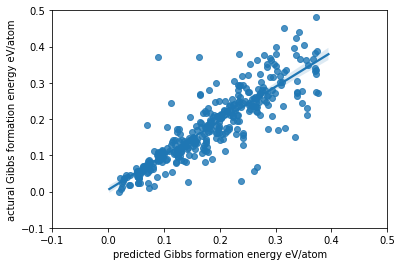

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=42)
#random_state is not being a very small number
rf.fit(pca_fit_X_train_std, y_train)

predicted_train = rf.predict(pca_fit_X_train_std)
predicted_test = rf.predict(pca_transform_X_test_std)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)

print('Test data Pearson correlation: %f'%pearson[0])
print('The test score would be: %f' %test_score) 
print ('Test data Spearman correlation: %f'%spearman[0])

sns.regplot(x=predicted_test, y=y_test) #,fit_reg=False)
plt.xlim(-0.1, 0.5)
plt.ylim(-0.1, 0.5)
# Set x-axis label
plt.xlabel('predicted Gibbs formation energy eV/atom')
# Set y-axis label
plt.ylabel('actural Gibbs formation energy eV/atom')
